### ***Theory of random forest***

As described in DT notebook, DT can be subject to high overfitting because they have low bias and high variance errors. The first is high if we have made a lot of assumptions abpout the target function, so if our modelling function is not flexible. The second, instead, refers to the variability of a target function w.r.t. different training samples: models with high varianvce will change a lot when small modifications of the training dataset are made. The idea used by RF to overcome this limitations is to build multiple trees and average their prediction for regression or use majority voting for classification. Each tree is built using a different dataset and a random subset of features.

To reduce the variance error, RF employs *bootstrap aggregation* (or *bagging*). Among the different techniques used for it, the one that will be used in this notebook was proposed by the inventors of RF Leo Breiman and Adele Cutler. Given a dataset $D=\{(X_1, y_1), \dots, (X_N, y_N)\}$ where $X_i$ are the features and $y_i$ the labels, we generate $B$ bootstraped samples $D_1, \dots, D_B$ by sampling with replacement $N$ tuples from $D$. Because replacement is allowed there might be some duplicate elements in $D_k$. Then, a decision tree $T_i$ is trained using $D_i$. Without bootrapping, all the trees would be highly correlated, i.e. if $T_i$ predicts label $\tilde y$, there's a high chance that also $T_k$ will predict $\tilde y$: consequently, if one overfits, also the other will overfit either. Note that this allows us to parallelize the training process: different machines will train one (or several) model.

Moreover, each $T_i$ is built considering only a random subset of $|F_i|=m$ features among the total $|F|=d$ features at eah best split call (see `DecisionTree.find_best_split(...)`): if we used the entire features vector, even with bootstrapping, there would be an high chance to keep using the mostly dominant features, not reducing correlation. Typically, $m=\sqrt{d}$ for classification and $m=\frac13d$ for regression. 

When it comes to make a prediction for a classification task, the idea is to use *majority voting*:
$$\tilde y = \argmax_{k}\,\,\sum_{i = 1}^{B}\mathbb{I}\{T_i(x) = k\}$$

where $k$ is a label, $\mathbb{I}\{...\}$ is the indicator function and $T_i(x)$ is the prediction of the $i\text{-th}$ tree.

Viceversa, for a regrassion task (not necessary in this notebook, but reported for the sake of completeness):
$$\tilde y = \frac1B\sum_{i=1}^{B}T_i(x)$$

### ***Model definition***

In [1]:
import numpy as np
from tqdm import tqdm
import scipy

import sys
sys.path.append("..")
from utils.models.DecisionTree import DecisionTree

In [2]:
class RandomForest:
    def __init__(self, 
                 n_trees = 10,
                 criterion = "gini", 
                 max_depth = None, 
                 min_samples_split = 2, 
                 min_samples_leaf = 1, 
                 min_impurity_decrease = 0.0,
                 max_thresholds = 1,
                 random_state = 0):
        
        """
            Initializes the decision tree parameters.
            
            Args:
                - Parameters of RF:
                    n_trees (int): number of trees to be built
                    random_state (int): random seed.
                
                - Paramters of DT to be built: 
                    criterion (str): the function to measure the quality of a split ("gini" or "entropy").
                    max_depth (int): the maximum depth of the tree.
                    min_samples_split (int): the minimum number of samples required to split an internal node.
                    min_samples_leaf (int): the minimum number of samples required to be at a leaf node.
                    min_impurity_decrease (float): the minimum impurity decrease required to split a node.
                    max_thresholds (int): the maximum number of thresholds to use during best split search.
                    max_features (str / float): the maximum number of features to choose from in the given ones: 
                                                    - if "sqrt", then int(sqrt(n_features)); 
                                                    - if "log2", then int(log2(n_features)):
                                                    - if float, then int(n_features * max_features);
                                                    - if None, all features
                    random_state (int): random seed.
        """
        
        self.n_trees = n_trees

        #When the traing process is complete, all the DecisionTree objects in this list will be trained
        self.trees = [DecisionTree(criterion = criterion,
                                   max_depth = max_depth,
                                   min_samples_split = min_samples_split,
                                   min_samples_leaf = min_samples_leaf,
                                   min_impurity_decrease = min_impurity_decrease,
                                   max_thresholds = max_thresholds,
                                   max_features = "sqrt", #As explained in the theory part, for classification tasks, sqrt(n_features) have to be used.
                                                          #Thus, we pass directly to the DT the parameter max_features = "sqrt", so that it will be the DT to selct randomly them;
                                                          #see for more details methods "build_tree(...)" and "find_best_split(...)" of DT.
                                   random_state = random_state)
                     for _ in range(self.n_trees)]

        self.random_state = random_state

    def fit(self, X, y):
        """
            Fit a RF model with the specified parameters to the data. 

            Args:
                X (np.ndarray): the matrix containing the features (sample on the rows);
                y (np.ndarray): the vector containg the labels.
        """
 
        for i in tqdm(range(self.n_trees), desc = "Training of RF"):
            #For each subtree that we have to build, we generate a bootstrapped dataset
            bs_ids = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace = True)
            X_bs = X[bs_ids]
            y_bs = y[bs_ids]

            #Then, we train the DT on it
            self.trees[i].fit(X_bs, y_bs)

    def predict(self, X):
        """
            This method predicts the labels of a given set of samples.

            Args:
                X (np.ndarray): the matrix containing the samples to be classified (samples on rows)

            Returns:
                labels (np.ndarray): the predicted label of each sample in X
                scores (np.ndarray): the score associated to each prediction
        """

        #As define in the theory part, we collect the prediction of each tree.
        #Note: the resulting matrix is n_trees x n_samples, so we have to compute the frequencies of the values
        #on the columns, not on the rows!
        predictions = np.array([t.predict(X) for t in self.trees])  
        
        #scipy.stats.mode (axis = 0) collets all the modes or "modal" (most common values) along with their frequencies
        labels, counts = scipy.stats.mode(predictions, axis = 0)

        #Finally, we normalize the frequencies so that they are in [0,1]
        scores = counts / predictions.shape[0]

        return labels, scores


### ***Usage of the model***

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import sys
sys.path.append("..")

from utils.preprocessing import undersample, fit_resample

import utils.model_evaluation as me
import matplotlib.pyplot as plt

In [4]:
#Load the dataset
init_data = pd.read_csv("../creditcard_2021.csv")
data = init_data[me.feature_vectors["v5"] + ["Class"]]

#"Class" column is the target variable, so we remove it from the feature matrix and store it in the variable y
X = data.drop(columns = ["Class"])
y = data["Class"]

X = np.array(X)
y = np.array(y)

In [5]:
#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [6]:
#Note: in constrant with what have been done for DT, here we apply SMOTE because we have observed experimentally that it increases the recall with slight decrease of the precision on the testing set
X_smote = fit_resample(X_train[y_train == 1], 2500, 10)

X_train = np.vstack((X_train, X_smote))
y_train = np.hstack((y_train, [1] * 2500))

In [7]:
rf = RandomForest(n_trees = 25,
                  criterion = "entropy", 
                  max_depth = 15, 
                  min_samples_split = 5, 
                  min_samples_leaf = 2, 
                  min_impurity_decrease = 1e-5, #Important parameter: small changes can lead to big differences in the tree and its performance
                  max_thresholds = 75, 
                  random_state = 0)

In [8]:
#Once defined, we can train the model
rf.fit(X_train, y_train)

Training of RF: 100%|██████████| 25/25 [03:24<00:00,  8.17s/it]


In [9]:
#Once trained, we can make predictions
y_pred, votes = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(85443,))

Precision: 0.921875
Recall: 0.8027210884353742
F1 Score: 0.8581818181818183
Accuracy: 0.9995435553526912
AUC Score: 0.9443946378964265


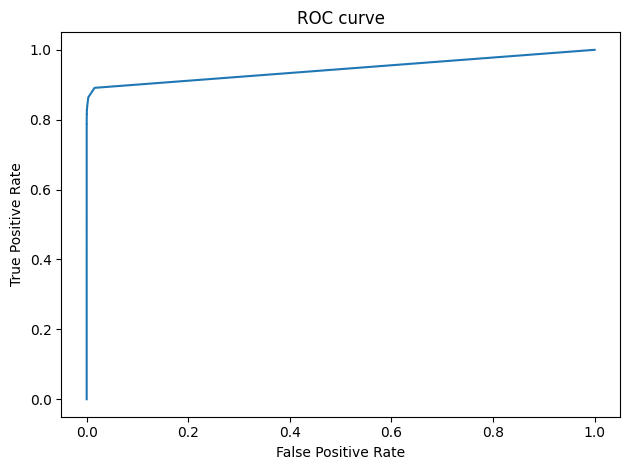

In [10]:
metrics = me.compute_metrics(y_test, y_pred)

print("Precision:", metrics["precision"][0])
print("Recall:", metrics["recall"][0])
print("F1 Score:", metrics["f1-score"][0])
print("Accuracy:", metrics["accuracy"][0])

votes[y_pred == 0] = 1 - votes[y_pred == 0]
fpr, tpr, auc = me.compute_roc_auc(y_test, votes)
print("AUC Score:", auc)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.tight_layout()
plt.show()

In [11]:
params = {
    "n_trees" : 25,
    "criterion" : "entropy", 
    "max_depth" : 15, 
    "min_samples_split" : 5, 
    "min_samples_leaf" : 2, 
    "min_impurity_decrease" : 1e-5, 
    "max_thresholds" : 75, 
    "random_state" : 0
}

metrics_training = pd.DataFrame()
metrics_testing = pd.DataFrame()

roc_auc_training = {}
roc_auc_testing = {}

for key, value in me.feature_vectors.items():
    print(f"Current feature vector: {value}")
    data = init_data[value + ["Class"]]
    X = data.drop(columns = ["Class"])
    X = np.array(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    rf = RandomForest(**params)

    rf.fit(X_train, y_train)
    y_pred, votes = rf.predict(X_train)
    votes[y_pred == 0] = 1 - votes[y_pred == 0]

    metrics_training = me.compute_metrics(y_train, y_pred, metrics_df = metrics_training, dataset_label = key)
    roc_auc_training[key] = me.compute_roc_auc(y_train, votes)

    y_pred, votes = rf.predict(X_test)
    votes[y_pred == 0] = 1 - votes[y_pred == 0]
    
    metrics_testing = me.compute_metrics(y_test, y_pred, metrics_df = metrics_testing, dataset_label = key)
    roc_auc_testing[key] = me.compute_roc_auc(y_test, votes)
    
    print("")

Current feature vector: ['V1', 'V5', 'V7', 'V8', 'V11', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'Amount']


Training of RF: 100%|██████████| 25/25 [03:47<00:00,  9.09s/it]



Current feature vector: ['V1', 'V6', 'V13', 'V16', 'V17', 'V22', 'V23', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [02:37<00:00,  6.29s/it]



Current feature vector: ['V2', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V24', 'V26', 'Amount']


Training of RF: 100%|██████████| 25/25 [02:41<00:00,  6.45s/it]



Current feature vector: ['V2', 'V7', 'V10', 'V13', 'V15', 'V17', 'V19', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [02:42<00:00,  6.50s/it]



Current feature vector: ['Time', 'V1', 'V7', 'V8', 'V9', 'V11', 'V12', 'V14', 'V15', 'V22', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [02:31<00:00,  6.06s/it]



Current feature vector: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [04:28<00:00, 10.74s/it]



Current feature vector: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 25/25 [04:17<00:00, 10.32s/it]


In [12]:
#Metrics for training
metrics_training

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,299,199019,0,46,0.999769,0.866667,1.000000,0.928571,199364,345
1,v2,280,199019,0,65,0.999674,0.811594,1.000000,0.896000,199364,345
2,v3,292,199018,1,53,0.999729,0.846377,0.996587,0.915361,199364,345
3,v4,285,199019,0,60,0.999699,0.826087,1.000000,0.904762,199364,345
4,v5,288,199018,1,57,0.999709,0.834783,0.996540,0.908517,199364,345
5,v6,298,199019,0,47,0.999764,0.863768,1.000000,0.926905,199364,345
6,v7,294,199019,0,51,0.999744,0.852174,1.000000,0.920188,199364,345


In [13]:
#Metrics for testing
metrics_testing

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,105,85291,5,42,0.999450,0.714286,0.954545,0.817121,85443,147
1,v2,95,85284,12,52,0.999251,0.646259,0.887850,0.748031,85443,147
2,v3,104,85288,8,43,0.999403,0.707483,0.928571,0.803089,85443,147
3,v4,112,85287,9,35,0.999485,0.761905,0.925620,0.835821,85443,147
4,v5,107,85291,5,40,0.999473,0.727891,0.955357,0.826255,85443,147
5,v6,113,85289,7,34,0.999520,0.768707,0.941667,0.846442,85443,147
6,v7,107,85292,4,40,0.999485,0.727891,0.963964,0.829457,85443,147


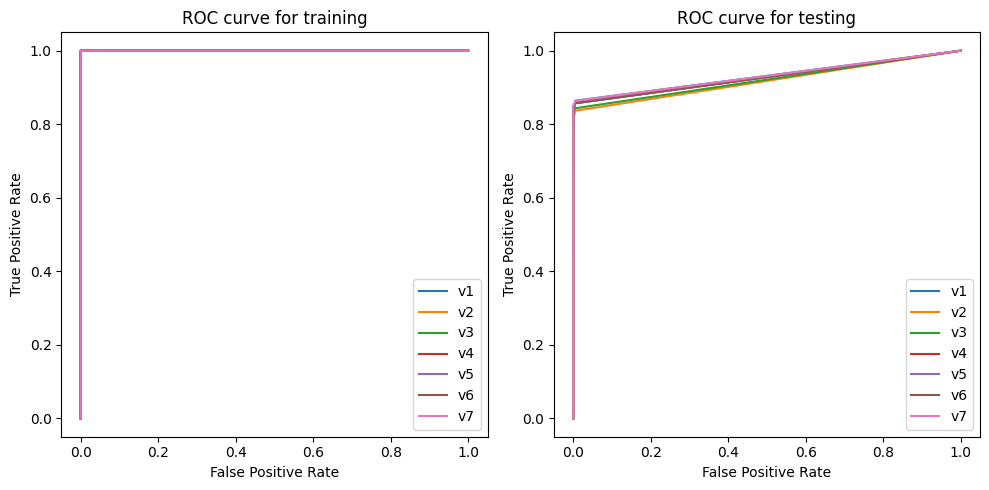

Training AUC:
v7 -> 0.999997203675332
v7 -> 0.9999883559293116
v7 -> 0.9999920989263934
v7 -> 0.9999884724428393
v7 -> 0.9999931257018574
v7 -> 0.9999969560840851
v7 -> 0.9999960895147219

Testing AUC:
v7 -> 0.9314593709365194
v7 -> 0.9178002940061787
v7 -> 0.9212712002827769
v7 -> 0.9280996820037339
v7 -> 0.9280985654438102
v7 -> 0.9281286328074656
v7 -> 0.9315214995208362


In [14]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

#ROC curve for training
for i in roc_auc_training.keys():
    axs[0].plot(roc_auc_training[i][0], roc_auc_training[i][1], label = i)
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve for training")
    axs[0].legend()

#ROC curve for testing
for i in roc_auc_testing.keys():
    axs[1].plot(roc_auc_testing[i][0], roc_auc_testing[i][1], label = i)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC curve for testing")
    axs[1].legend()

plt.tight_layout()
plt.show()

print("Training AUC:")
for i, auc in roc_auc_training.items():
    print(f"{key} -> {auc[2]}")

print("\nTesting AUC:")
for i, auc in roc_auc_testing.items():
    print(f"{key} -> {auc[2]}")

In [15]:
#One thing that we can try to do is undersampling:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, y_train = undersample(X_train, y_train, 0, 1 - (sum(y_train) * 300.0 / X_train.shape[0]))

In [16]:
rf = RandomForest(n_trees = 20,
                  criterion = "gini", 
                  max_depth = 10, 
                  min_samples_split = 2, 
                  min_samples_leaf = 1, 
                  min_impurity_decrease = 0.0, #Important parameter: small changes can lead to big differences in the tree and its performance (1e-5)
                  max_thresholds = 20, 
                  random_state = 0)

In [17]:
#Once defined, we can train the model
rf.fit(X_train, y_train)

Training of RF: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


In [18]:
#Once trained, we can make predictions
y_pred, votes = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(85443,))

Precision: 0.954954954954955
Recall: 0.7210884353741497
F1 Score: 0.8217054263565892
Accuracy: 0.9994616293903538
AUC Score: 0.9213187338338074


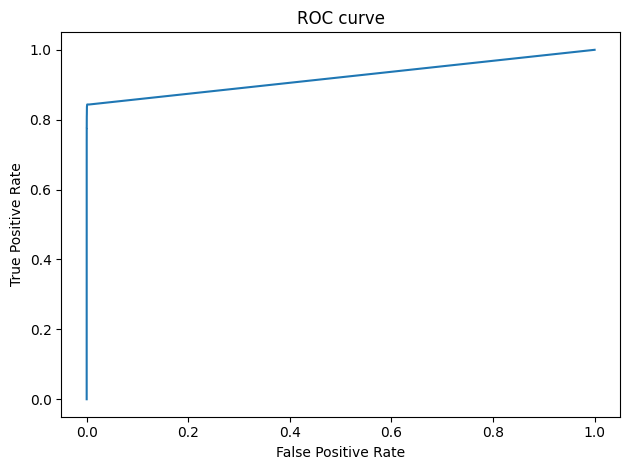

In [19]:
metrics = me.compute_metrics(y_test, y_pred)

print("Precision:", metrics["precision"][0])
print("Recall:", metrics["recall"][0])
print("F1 Score:", metrics["f1-score"][0])
print("Accuracy:", metrics["accuracy"][0])

votes[y_pred == 0] = 1 - votes[y_pred == 0]
fpr, tpr, auc = me.compute_roc_auc(y_test, votes)
print("AUC Score:", auc)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.tight_layout()
plt.show()

In [21]:
params = {
    "n_trees" : 20,
    "criterion" : "gini", 
    "max_depth" : 10, 
    "min_samples_split" : 2, 
    "min_samples_leaf" : 1, 
    "min_impurity_decrease" : 0, 
    "max_thresholds" : 20, 
    "random_state" : 0
}

metrics_training_2 = pd.DataFrame()
metrics_testing_2 = pd.DataFrame()

roc_auc_training = {}
roc_auc_testing = {}

for key, value in me.feature_vectors.items():
    print(f"Current feature vector: {value}")
    data = init_data[value + ["Class"]]
    X = data.drop(columns = ["Class"])
    X = np.array(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    rf = RandomForest(**params)

    rf.fit(X_train, y_train)
    y_pred, votes = rf.predict(X_train)
    votes[y_pred == 0] = 1 - votes[y_pred == 0]

    metrics_training_2 = me.compute_metrics(y_train, y_pred, metrics_df = metrics_training_2, dataset_label = key)
    roc_auc_training[key] = me.compute_roc_auc(y_train, votes)

    y_pred, votes = rf.predict(X_test)
    votes[y_pred == 0] = 1 - votes[y_pred == 0]
    
    metrics_testing_2 = me.compute_metrics(y_test, y_pred, metrics_df = metrics_testing_2, dataset_label = key)
    roc_auc_testing[key] = me.compute_roc_auc(y_test, votes)
    
    print("")

Current feature vector: ['V1', 'V5', 'V7', 'V8', 'V11', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:51<00:00,  2.55s/it]



Current feature vector: ['V1', 'V6', 'V13', 'V16', 'V17', 'V22', 'V23', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]



Current feature vector: ['V2', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V24', 'V26', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:38<00:00,  1.90s/it]



Current feature vector: ['V2', 'V7', 'V10', 'V13', 'V15', 'V17', 'V19', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]



Current feature vector: ['Time', 'V1', 'V7', 'V8', 'V9', 'V11', 'V12', 'V14', 'V15', 'V22', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]



Current feature vector: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [01:01<00:00,  3.09s/it]



Current feature vector: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


Training of RF: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


In [22]:
#Metrics for training
metrics_training_2

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,296,199019,0,49,0.999754,0.857971,1.000000,0.923557,199364,345
1,v2,284,199017,2,61,0.999684,0.823188,0.993007,0.900158,199364,345
2,v3,285,199019,0,60,0.999699,0.826087,1.000000,0.904762,199364,345
3,v4,291,199018,1,54,0.999724,0.843478,0.996575,0.913658,199364,345
4,v5,280,199018,1,65,0.999669,0.811594,0.996441,0.894569,199364,345
5,v6,295,199019,0,50,0.999749,0.855072,1.000000,0.921875,199364,345
6,v7,296,199019,0,49,0.999754,0.857971,1.000000,0.923557,199364,345


In [23]:
#Metrics for testing
metrics_testing_2

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1,104,85291,5,43,0.999438,0.707483,0.954128,0.812500,85443,147
1,v2,95,85284,12,52,0.999251,0.646259,0.887850,0.748031,85443,147
2,v3,107,85288,8,40,0.999438,0.727891,0.930435,0.816794,85443,147
3,v4,104,85286,10,43,0.999380,0.707483,0.912281,0.796935,85443,147
4,v5,107,85291,5,40,0.999473,0.727891,0.955357,0.826255,85443,147
5,v6,109,85290,6,38,0.999485,0.741497,0.947826,0.832061,85443,147
6,v7,109,85290,6,38,0.999485,0.741497,0.947826,0.832061,85443,147


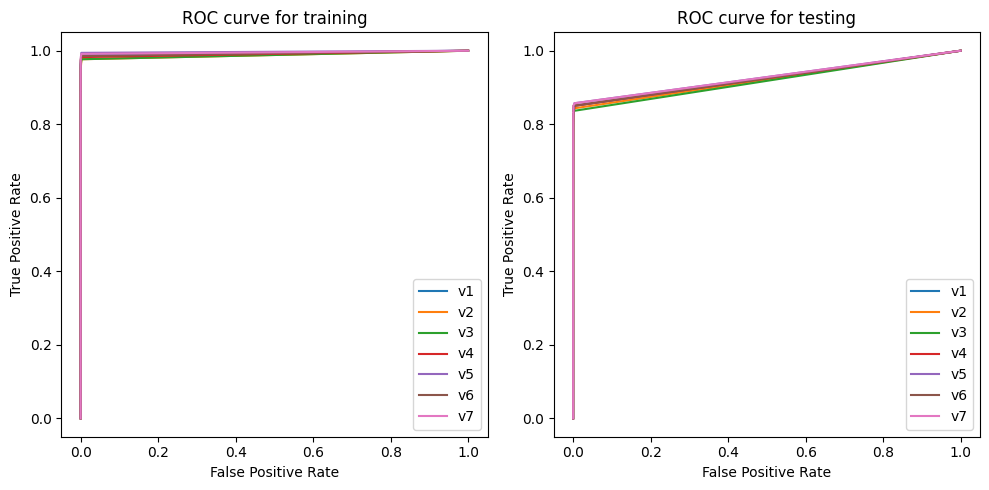

Training AUC:
v7 -> 0.9941589802328246
v7 -> 0.9883380881775835
v7 -> 0.9883510940001287
v7 -> 0.9912614344373646
v7 -> 0.997060931696056
v7 -> 0.9927237593148014
v7 -> 0.995626096729094

Testing AUC:
v7 -> 0.9248301951619139
v7 -> 0.921349877880246
v7 -> 0.9179881950904542
v7 -> 0.9247531525271898
v7 -> 0.9282688009550097
v7 -> 0.924884826843887
v7 -> 0.928263537172513


In [24]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

#ROC curve for training
for i in roc_auc_training.keys():
    axs[0].plot(roc_auc_training[i][0], roc_auc_training[i][1], label = i)
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve for training")
    axs[0].legend()

#ROC curve for testing
for i in roc_auc_testing.keys():
    axs[1].plot(roc_auc_testing[i][0], roc_auc_testing[i][1], label = i)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC curve for testing")
    axs[1].legend()

plt.tight_layout()
plt.show()

print("Training AUC:")
for i, auc in roc_auc_training.items():
    print(f"{key} -> {auc[2]}")

print("\nTesting AUC:")
for i, auc in roc_auc_testing.items():
    print(f"{key} -> {auc[2]}")